# snmCAT-seq integration using SingleCellFusion

Fangming Xie
- Originally produced on Oct 1, 2019
- Cleaned up and reproduced on Feb 22, 2021

This is a prototype notebook for our algorithm--SingleCellFusion, applied on snmCAT-seq data (https://www.biorxiv.org/content/10.1101/2019.12.11.873398v1).
Run this notebook in the conda environment specified here: https://github.com/mukamel-lab/SingleCellFusion.

In [1]:
DATA_DIR = '../input/SingleCellFusion_format'
SCRIPTS_DIR = './scripts'
RESULTS_DIR = './results'

import sys

sys.path.insert(0, SCRIPTS_DIR)
from __init__ import *
import basic_utils
import clst_utils

sys.path.insert(0, DATA_DIR)
from __init__datasets import *

import re
import functools
import itertools
import collections
from scipy import sparse
from scipy.stats import zscore
import fbpca

import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
np.random.seed(0)

In [3]:
name = 'snmcatseq_210222'
output_pcX_all = os.path.join(RESULTS_DIR, 'pcX_all_{}.npy'.format(name))
output_cells_all = os.path.join(RESULTS_DIR, 'cells_all_{}.npy'.format(name))
output_clst_and_umap = os.path.join(RESULTS_DIR, 'intg_summary_{}.tsv'.format(name))
output_figures = os.path.join(RESULTS_DIR, '{}_{{}}.{{}}'.format(name))
SAVE_KNN_MAT = True
output_knn_mat = os.path.join(RESULTS_DIR, 'knn_{}_{{}}_from_{{}}.npz'.format(name))

In [4]:
log = basic_utils.create_logger()
logging.info('*')

02/22/2021 03:59:27 PM *


## Basic setups
- metadata
- feature (highly variable) matrix

In [5]:
mods_selected = [
    'human_frontal_rna',
    'human_frontal_mch',
    ]
mod_i, mod_j = 'human_frontal_rna', 'human_frontal_mch'

features_selected = mods_selected.copy() 
features_selected = ['human_frontal_mch']

mod = mod_i
mods_selected

['human_frontal_rna', 'human_frontal_mch']

In [6]:
# within modality
ps = {'mc': 0.9,
      'rna': 0.7,
     }

drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }
# across modality
KNN = 10 
RELAXATION = 2 

# PCA
npc = 50

# clustering
k = 30
resolutions = [0.3, 0.5, 0.8, 4]
# umap
umap_neighbors = 30
min_dist=min_dist = 0.5

In [7]:
# cell-level metadata
meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
metas = collections.OrderedDict()

for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(metas[mod].iloc[:1, :2], len(metas[mod]))

                                   index  Technology
sample                                              
UMB5577_1_UMB5577_2_A10_AD001_rna      0  snmCT-NOMe 3898
                                   index  Technology
sample                                              
UMB5577_1_UMB5577_2_A10_AD001_mch      0  snmCT-NOMe 3898


In [8]:
# gene-by-cell matrices
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        
        # subsample
        gxc_hvftrs[mod] = gxc_hvftrs[mod][metas[mod].index.values]
        
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    
    _mat = sparse.load_npz(f_mat) 
    _gene = pd.read_csv(f_gene, sep='\t', header=None).iloc[:, 0].values
    _cell = pd.read_csv(f_cell, sep='\t', header=None).iloc[:, 0].values 
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

human_frontal_rna
(5107, 3898) 0.7307157516479492
human_frontal_mch
(5107, 3898) 4.950886964797974


## smooth within modality

In [9]:
# smooth-within modality
def smooth_in_modality(counts_matrix, norm_counts_matrix, k, ka, npc=100, sigma=1.0, p=0.1, drop_npc=0):
    """Smooth a data matrix
    
    Arguments:
        - counts_matrix (pandas dataframe, feature by cell)
        - norm_counts_matrix (pandas dataframe, feature by cell) log10(CPM+1)
        - k (number of nearest neighbors)
    Return:
        - smoothed cells_matrix (pandas dataframe)
        - markov affinity matrix
    """
    from sklearn.neighbors import NearestNeighbors
    import fbpca
    
    assert counts_matrix.shape[1] == norm_counts_matrix.shape[1] 

    c = norm_counts_matrix.columns.values
    N = len(c)

    # reduce dimension fast version
    U, s, Vt = fbpca.pca(norm_counts_matrix.T.values, k=npc)
    pcs = U.dot(np.diag(s))
    if drop_npc != 0:
        pcs = pcs[:, drop_npc:]

    # get k nearest neighbor distances fast version 
    inds, dists = clst_utils.gen_knn_annoy(pcs, k, form='list', 
                                                metric='euclidean', n_trees=10, search_k=-1, verbose=True, 
                                                include_distances=True)
    
    # remove itself
    dists = dists[:, 1:]
    inds = inds[:, 1:]

    # normalize by ka's distance 
    dists = (dists/(dists[:, ka].reshape(-1, 1)))

    # gaussian kernel
    adjs = np.exp(-((dists**2)/(sigma**2))) 

    # construct a sparse matrix 
    cols = np.ravel(inds)
    rows = np.repeat(np.arange(N), k-1) # remove itself
    vals = np.ravel(adjs)
    A = sparse.csr_matrix((vals, (rows, cols)), shape=(N, N))

    # Symmetrize A (union of connection)
    A = A + A.T

    # normalization fast (A is now a weight matrix excluding itself)
    degrees = A.sum(axis=1)
    A = sparse.diags(1.0/np.ravel(degrees)).dot(A)

    # include itself
    eye = sparse.identity(N)
    A = p*eye + (1-p)*A
    
    # smooth fast (future?)
    counts_matrix_smoothed = pd.DataFrame((A.dot(counts_matrix.T)).T, 
                                         columns=counts_matrix.columns, index=counts_matrix.index)
    return counts_matrix_smoothed, A


In [10]:
# GENE * CELL matrices
smoothed_features = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        _df = gxc_hvftrs[mod]
    else:
        _mat = gxc_hvftrs[mod].data.todense()
        _df = pd.DataFrame(_mat, 
                          index=gxc_hvftrs[mod].gene, 
                          columns=gxc_hvftrs[mod].cell, 
                          ) 
        
    mat_smoothed, mat_knn = smooth_in_modality(_df, _df, k=30, ka=5, npc=50, p=ps[settings[mod].mod_category], drop_npc=drop_npcs[settings[mod].mod_category])
    smoothed_features[mod] = mat_smoothed
    print(smoothed_features[mod].shape)
    print(time.time() - ti)
    

human_frontal_rna
Time used to build kNN map 0.23609495162963867
Time used to get kNN 0.15149998664855957
(5107, 3898)
2.960575819015503
human_frontal_mch
Time used to build kNN map 0.14171123504638672
Time used to get kNN 0.16182255744934082
(5107, 3898)
2.1898114681243896


## Impute across modalities

In [11]:
def get_constrained_knn(mat_norm_j, mat_norm_i, knn, k_saturate, knn_speed_factor=10, metric='dot'):
    """Get constrained knn
    j <- i
    Look for kNN in i for each cell in j, cells in i are constrained to k_saturated
    
    get knn_speed_factor*knn number of nearest neighbors internally
    """
    ti = time.time()
    assert mat_norm_i.shape[1] == mat_norm_j.shape[1]
    knn = int(knn)
    knn_speed_factor = int(knn_speed_factor)
    
    cells_i = np.arange(len(mat_norm_i))
    cells_j = np.arange(len(mat_norm_j))
    
    # record cells in j
    accepted_knn_ji = [] 
    accepted_cells = []
    rejected_cells = np.arange(len(cells_j))
    
    # record cell in i
    n_connects = np.zeros(len(cells_i)).astype(int) # record number of connection for each cell in i 
    unsaturated = (n_connects < k_saturate) # unsaturated bool 
    unsaturated_cells = np.arange(len(cells_i))[unsaturated]
    
    while rejected_cells.size != 0:
        print(len(rejected_cells), len(unsaturated_cells), time.time()-ti)
        
        np.random.shuffle(rejected_cells) # random order
        # do something to rejected cells and unsaturated cells
        # knn_ji # for each cell in j, its knn in i
        knn_ji = clst_utils.gen_knn_annoy_train_test(mat_norm_i.values[unsaturated_cells], # look for nearest neighbors in i 
                                                           mat_norm_j.values[rejected_cells], # for each row in j
                                                           min(knn*knn_speed_factor, len(unsaturated_cells)), #  
                                                           form='list', # adj matrix 
                                                           metric=metric, # correlation 
                                                           n_trees=10, search_k=-1, verbose=False, 
                                                           include_distances=False, # for now
                                                           ).astype(int)
        knn_ji = unsaturated_cells[knn_ji] # transform it to global index, need to check this like 
        
        rejected_local_idx = []
        # examine each cell in j
        for local_idx, cell in enumerate(rejected_cells):
            # get knn in i
            knn_in_i = knn_ji[local_idx]
            # filter out saturated ones
            knn_in_i = knn_in_i[unsaturated[knn_in_i]]
            
            if knn_in_i.size < knn:
                # reject
                rejected_local_idx.append(local_idx)
            else:
                # accept and update
                accepted_knn_ji.append(knn_in_i[:knn])
                accepted_cells.append(cell)
                n_connects[knn_in_i[:knn]] += 1 
                unsaturated = (n_connects < k_saturate) # unsaturated bool 
                
        unsaturated_cells = np.arange(len(cells_i))[unsaturated]
        rejected_cells = rejected_cells[rejected_local_idx]
#         break
                
    accepted_knn_ji = pd.DataFrame(np.vstack(accepted_knn_ji), index=accepted_cells)
    accepted_knn_ji = accepted_knn_ji.sort_index().values
    
    return accepted_knn_ji
    

In [12]:
def sparse_adj_to_mat(adjs, row_size, col_size, dists=''):
    """Turn a knn adjacency matrix to a sparse matrix
    """
    n_obs, k = adjs.shape
    assert n_obs == row_size
    # row col 1/dist 
    row_inds = np.repeat(np.arange(row_size), k)
    col_inds = np.ravel(adjs)
    if isinstance(dists, np.ndarray):
        assert dists.shape == adjs.shape
        data = np.ravel(dists) 
    else:
        data = [1]*len(row_inds)
    knn_dist_mat = sparse.coo_matrix((data, (row_inds, col_inds)), shape=(row_size, col_size))
    return knn_dist_mat


In [13]:
mod_pairs = list(itertools.combinations(mods_selected, 2))
mod_pairs

[('human_frontal_rna', 'human_frontal_mch')]

In [14]:
imputed_features = collections.OrderedDict()

for mod_i, mod_j in mod_pairs: # i - m, j - h
    ti = time.time()
    
    # set up
    direct_i, direct_j = settings[mod_i].mod_direction, settings[mod_j].mod_direction
    print(mod_i, direct_i, mod_j, direct_j)
    
    genes_i = smoothed_features[mod_i].index.values
    genes_j = smoothed_features[mod_j].index.values
    genes_common = np.intersect1d(genes_i, genes_j)
    
    mat_ii = smoothed_features[mod_i].T # cell in mod i; gene in mod i
    mat_jj = smoothed_features[mod_j].T # cell in mod j; gene in mod j
    
    cells_i = mat_ii.index.values
    cells_j = mat_jj.index.values
    print(genes_i.shape, genes_j.shape, genes_common.shape)
    
#     ## spearman correlation as distance  (rank -> zscore -> (flip sign?) -> "dot" distance) 
#     # normalize the feature matrix
#     mat_norm_i = (mat_ii[genes_common].rank(pct=True, axis=1)
#                                       .apply(basic_utils.zscore, axis=1)
#                                       *direct_i
#                  )
#     mat_norm_j = (mat_jj[genes_common].rank(pct=True, axis=1)
#                                       .apply(basic_utils.zscore, axis=1)
#                                       *direct_j
#                  )

    ## CCA euclidean distance 
    # normalize the feature matrix
    X = mat_ii[genes_common].T.apply(basic_utils.zscore, axis=0)*direct_i # gene by cell, zscore across genes
    Y = mat_jj[genes_common].T.apply(basic_utils.zscore, axis=0)*direct_j
    U, s, Vt = fbpca.pca(X.T.values.dot(Y.values), k=20)

    mat_norm_i = pd.DataFrame(U, index=mat_ii.index)
    mat_norm_j = pd.DataFrame(Vt.T, index=mat_jj.index)

    
    # look for knn (dot distance)
    knn = KNN
    relaxation = RELAXATION
    maxk_i = int((len(cells_j)/len(cells_i))*knn*relaxation)+1 # max number of NN a cell in i can get 
    maxk_j = int((len(cells_i)/len(cells_j))*knn*relaxation)+1 # max number of NN a cell in j can get 
    print(knn, maxk_i, maxk_j)
    
    # knn_i and knn_j
    # j <- i for each j, get kNN in i
    knn_ji = get_constrained_knn(mat_norm_j, mat_norm_i, knn=knn, k_saturate=maxk_i, metric='euclidean')
    mat_knn_ji = sparse_adj_to_mat(knn_ji, len(cells_j), len(cells_i))
    
    # i <- j
    knn_ij = get_constrained_knn(mat_norm_i, mat_norm_j, knn=knn, k_saturate=maxk_j, metric='euclidean')
    mat_knn_ij = sparse_adj_to_mat(knn_ij, len(cells_i), len(cells_j))
    
    if SAVE_KNN_MAT:
        f = output_knn_mat.format(mod_i, mod_j)
        sparse.save_npz(f, mat_knn_ij)
        f = output_knn_mat.format(mod_j, mod_i)
        sparse.save_npz(f, mat_knn_ji)
    
    # normalize 
    degrees_j = np.ravel(mat_knn_ji.sum(axis=1)) # for each cell in j, how many cells in i it connects to 
    mat_knn_ji = sparse.diags(1.0/(degrees_j+1e-7)).dot(mat_knn_ji) 
    
    degrees_i = np.ravel(mat_knn_ij.sum(axis=1)) # for each cell in i, how many cells in j it connects to 
    mat_knn_ij = sparse.diags(1.0/(degrees_i+1e-7)).dot(mat_knn_ij) 
    
    # imputation both across and within modality
    mat_ji = mat_knn_ji.dot(mat_ii) # cell in mod j, gene in mod i
    mat_ij = mat_knn_ij.dot(mat_jj) # cell in mod i, gene in mod j
    
    imputed_features[(mod_i, mod_j)] = mat_ij # cell in mod i, gene in mod j
    imputed_features[(mod_j, mod_i)] = mat_ji
    
#     break

human_frontal_rna 1 human_frontal_mch -1
(5107,) (5107,) (5107,)
10 21 21
3898 3898 0.00011873245239257812
3898 3898 5.435943603515625e-05


In [15]:
# imputed_features cell by gene
# smoothed_features gene by cell
all_features = collections.OrderedDict() #(mod_x, mod_y) first for cells, second for genes
for mod_x in mods_selected:
    for mod_y in mods_selected:
        print(mod_x, mod_y)
        if mod_x == mod_y:
            all_features[(mod_x, mod_y)] = smoothed_features[mod_x].T #### THIS WAS GENE*CELL 
        else:
            all_features[(mod_x, mod_y)] = imputed_features[(mod_x, mod_y)] 
            
# del imputed_features, smoothed_features # restore this later

human_frontal_rna human_frontal_rna
human_frontal_rna human_frontal_mch
human_frontal_mch human_frontal_rna
human_frontal_mch human_frontal_mch


In [16]:
for mod_x in mods_selected:
    for mod_y in mods_selected:
        _ = all_features[(mod_x, mod_y)].shape
        print(_)

(3898, 5107)
(3898, 5107)
(3898, 5107)
(3898, 5107)


In [17]:
# construct the joint matrix (PCA)
cells_all = np.hstack([metas[mod].index.values for mod in mods_selected]) # cell (all mods) by gene (mod_y) 
pcX_all = []
for mod_y in mods_selected: ## to 
    ti = time.time()
    print(mod_y)
    
    if mod_y in features_selected:
        X = np.vstack([all_features[(mod_x, mod_y)] for mod_x in mods_selected]) # cell (all mods) by gene (mod_y) 

        # PCA
        U, s, V = fbpca.pca(X, npc)
        del X
        pcX = U.dot(np.diag(s))
        # normalize PCs
        sigma = np.sqrt(np.sum(s*s)/(pcX.shape[0]*pcX.shape[1]))
        pcX = pcX/sigma

        pcX_all.append(pcX)
        print(pcX.shape)
        print(time.time()-ti)
    
pcX_all = np.hstack(pcX_all)
print(pcX_all.shape, cells_all.shape)
print(time.time()-ti)

# save pcX_all
np.save(output_pcX_all, pcX_all)
np.save(output_cells_all, cells_all)
print(output_pcX_all)
print(output_cells_all)

pcX_all = np.load(output_pcX_all, allow_pickle=True)
cells_all = np.load(output_cells_all, allow_pickle=True)

# clustering
df_clsts = []
for resolution in resolutions:
    print('resolution r: {}'.format(resolution))
    df_clst = clst_utils.clustering_routine(
                                    pcX_all, 
                                    cells_all, k, 
                                    resolution=resolution,
                                    metric='euclidean', option='plain', n_trees=10, search_k=-1)
    print(len(df_clst['cluster'].unique()))
    df_clsts.append(df_clst.rename(columns={'cluster': 
                                            'cluster_joint_r{}'.format(resolution)
                                           }))
df_clst = pd.concat(df_clsts, axis=1) 
print(df_clst.shape)

human_frontal_rna
human_frontal_mch
(7796, 50)
3.6680588722229004
(7796, 50) (7796,)
3.673246145248413
./results/pcX_all_snmcatseq_210222.npy
./results/cells_all_snmcatseq_210222.npy
resolution r: 0.3
Time used to build kNN map 0.236985445022583
Time used to get kNN 0.2995009422302246
Time spent on leiden clustering: 0.29967713356018066
16
resolution r: 0.5
Time used to build kNN map 0.1049644947052002
Time used to get kNN 0.2446577548980713
Time spent on leiden clustering: 0.302501916885376
17
resolution r: 0.8
Time used to build kNN map 0.11289501190185547
Time used to get kNN 0.26494789123535156
Time spent on leiden clustering: 0.29737377166748047
22
resolution r: 4
Time used to build kNN map 0.15246796607971191
Time used to get kNN 0.26268911361694336
Time spent on leiden clustering: 0.2942237854003906
50
(7796, 4)


In [18]:
print(pcX_all.shape)
print(cells_all.shape)

(7796, 50)
(7796,)


In [19]:
# umap
df_umap = clst_utils.run_umap_lite(
            pcX_all, 
            cells_all, n_neighbors=umap_neighbors, min_dist=min_dist, n_dim=2, 
            random_state=1)
 
df_summary = df_clst.join(df_umap)
df_summary['modality'] = ''

for mod in mods_selected:
    _cells = metas[mod].index.values
    df_summary.loc[_cells, 'modality'] = mod
    
# save results
df_summary.to_csv(output_clst_and_umap, sep='\t', header=True, index=True)
print(output_clst_and_umap)
print(df_summary.shape)
df_summary.head()

02/22/2021 03:59:58 PM Running UMAP: 30 n_neighbors, 0.5 min_dist , 2 dim.
Input shape: (7796, 50)
/cndd/fangming/venvs/scf_lite/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../cndd/fangming/venvs/scf_lite/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/cndd/fangming/venvs/scf_lite/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parall

./results/intg_summary_snmcatseq_210222.tsv
(7796, 7)


,cluster_joint_r0.3,cluster_joint_r0.5,cluster_joint_r0.8,cluster_joint_r4,tsne_x,tsne_y,modality
sample,,,,,,,
UMB5577_1_UMB5577_2_A10_AD001_rna,2,3,1,1,12.885162,-4.573042,human_frontal_rna
UMB5577_1_UMB5577_2_A10_AD002_rna,1,2,2,12,7.687022,-11.027214,human_frontal_rna
UMB5577_1_UMB5577_2_A10_AD004_rna,7,8,9,6,5.291834,4.748993,human_frontal_rna
UMB5577_1_UMB5577_2_A10_AD006_rna,9,10,11,9,-0.954100,6.527846,human_frontal_rna
UMB5577_1_UMB5577_2_A10_AD007_rna,12,13,13,16,19.809443,0.406097,human_frontal_rna


## All done, making plots after 

In [20]:
import json
f = './Palette/Modality_Palette.json'
mod_colors = json.load(open(f), object_pairs_hook=collections.OrderedDict)    

mod_colors['human_frontal_mch'] = mod_colors['mCH']
mod_colors[settings['human_frontal_mch'].name] = mod_colors['mCH']
mod_colors['human_frontal_rna'] = mod_colors['RNA']
mod_colors[settings['human_frontal_rna'].name] = mod_colors['RNA']
mod_colors

f = './Palette/Sub_Cluster_Palette.json'
subtype_colors = json.load(open(f), object_pairs_hook=collections.OrderedDict)    
subtype_ranks = collections.OrderedDict({key: i for i, (key, val) in enumerate(subtype_colors.items())})

f = './Palette/Major_Cluster_Palette.json'
majortype_colors = json.load(open(f), object_pairs_hook=collections.OrderedDict)    
majortype_ranks = collections.OrderedDict({key: i for i, (key, val) in enumerate(majortype_colors.items())})
majortype_colors

OrderedDict([('Exc_L1-3_CUX2', '#1f77b4'),
             ('Exc_L2-4_RORB', '#205a83'),
             ('Exc_L4_PLCH1', '#ff6347'),
             ('Exc_L4-5_FOXP2', '#9a2526'),
             ('Exc_L4-5_TOX', '#daa520'),
             ('Exc_L4-6_LRRK1', '#8c564b'),
             ('Exc_L5-6_PDZRN4', '#d62728'),
             ('Exc_L6_TLE4', '#ff7f0e'),
             ('Exc_L6_TSHZ2', '#b56014'),
             ('Inh_MGE_CALB1', '#b393d0'),
             ('Inh_MGE_B3GAT2', '#775596'),
             ('Inh_MGE_PVALB', '#9467bd'),
             ('Inh_MGE_UNC5B', '#5a446f'),
             ('Inh_CGE_VIP', '#ea9dd3'),
             ('Inh_CGE_NDNF', '#e377c2'),
             ('Inh_CGE_LAMP5', '#b26199'),
             ('Inh_CGE-MGE_CHST9', '#824c71'),
             ('NonN_Astro_FGF3R', '#298029'),
             ('NonN_Oligo_MBP', '#2ca02c'),
             ('NonN_Micro-Endo_TYROBP', '#266026'),
             ('Outlier', '#b2b2b2')])

In [21]:
for mod in mods_selected:
    metas[mod]['majortype_rank'] = metas[mod]['ClusterAnno'].apply(lambda x: majortype_ranks[x])
    metas[mod]['subtype_rank'] = metas[mod]['SubClusterAnno'].apply(lambda x: subtype_ranks[x])

In [22]:
f = output_clst_and_umap 

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]
    df_info.loc[_cells, 'sub_cluster'] = metas[mod].loc[_cells, 'SubClusterAnno']
    df_info.loc[_cells, 'sub_annot'] = metas[mod].loc[_cells, 'SubClusterAnno']

majorclst_annot = df_info.groupby('cluster').first()['annot']
subclst_annot = df_info.groupby('sub_cluster').first()['sub_annot']
print(df_info.shape)
df_info.head()

(7796, 12)


,cluster_joint_r0.3,cluster_joint_r0.5,cluster_joint_r0.8,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,sub_cluster,sub_annot
sample,,,,,,,,,,,,
UMB5577_1_UMB5577_2_A10_AD001_rna,2,3,1,1,12.885162,-4.573042,human_frontal_rna,mCT - RNA,20,Exc_L2-4_RORB,Exc_L2-4_RORB_-,Exc_L2-4_RORB_-
UMB5577_1_UMB5577_2_A10_AD002_rna,1,2,2,12,7.687022,-11.027214,human_frontal_rna,mCT - RNA,10,Exc_L1-3_CUX2,Exc_L1-3_CUX2_SLC35F3,Exc_L1-3_CUX2_SLC35F3
UMB5577_1_UMB5577_2_A10_AD004_rna,7,8,9,6,5.291834,4.748993,human_frontal_rna,mCT - RNA,8,Inh_MGE_PVALB,Inh_MGE_PVALB_DISC1,Inh_MGE_PVALB_DISC1
UMB5577_1_UMB5577_2_A10_AD006_rna,9,10,11,9,-0.954100,6.527846,human_frontal_rna,mCT - RNA,15,Inh_MGE_B3GAT2,Inh_MGE_B3GAT2_AOAH,Inh_MGE_B3GAT2_AOAH
UMB5577_1_UMB5577_2_A10_AD007_rna,12,13,13,16,19.809443,0.406097,human_frontal_rna,mCT - RNA,9,Exc_L5-6_PDZRN4,Exc_L5-6_PDZRN4_RGS6,Exc_L5-6_PDZRN4_RGS6


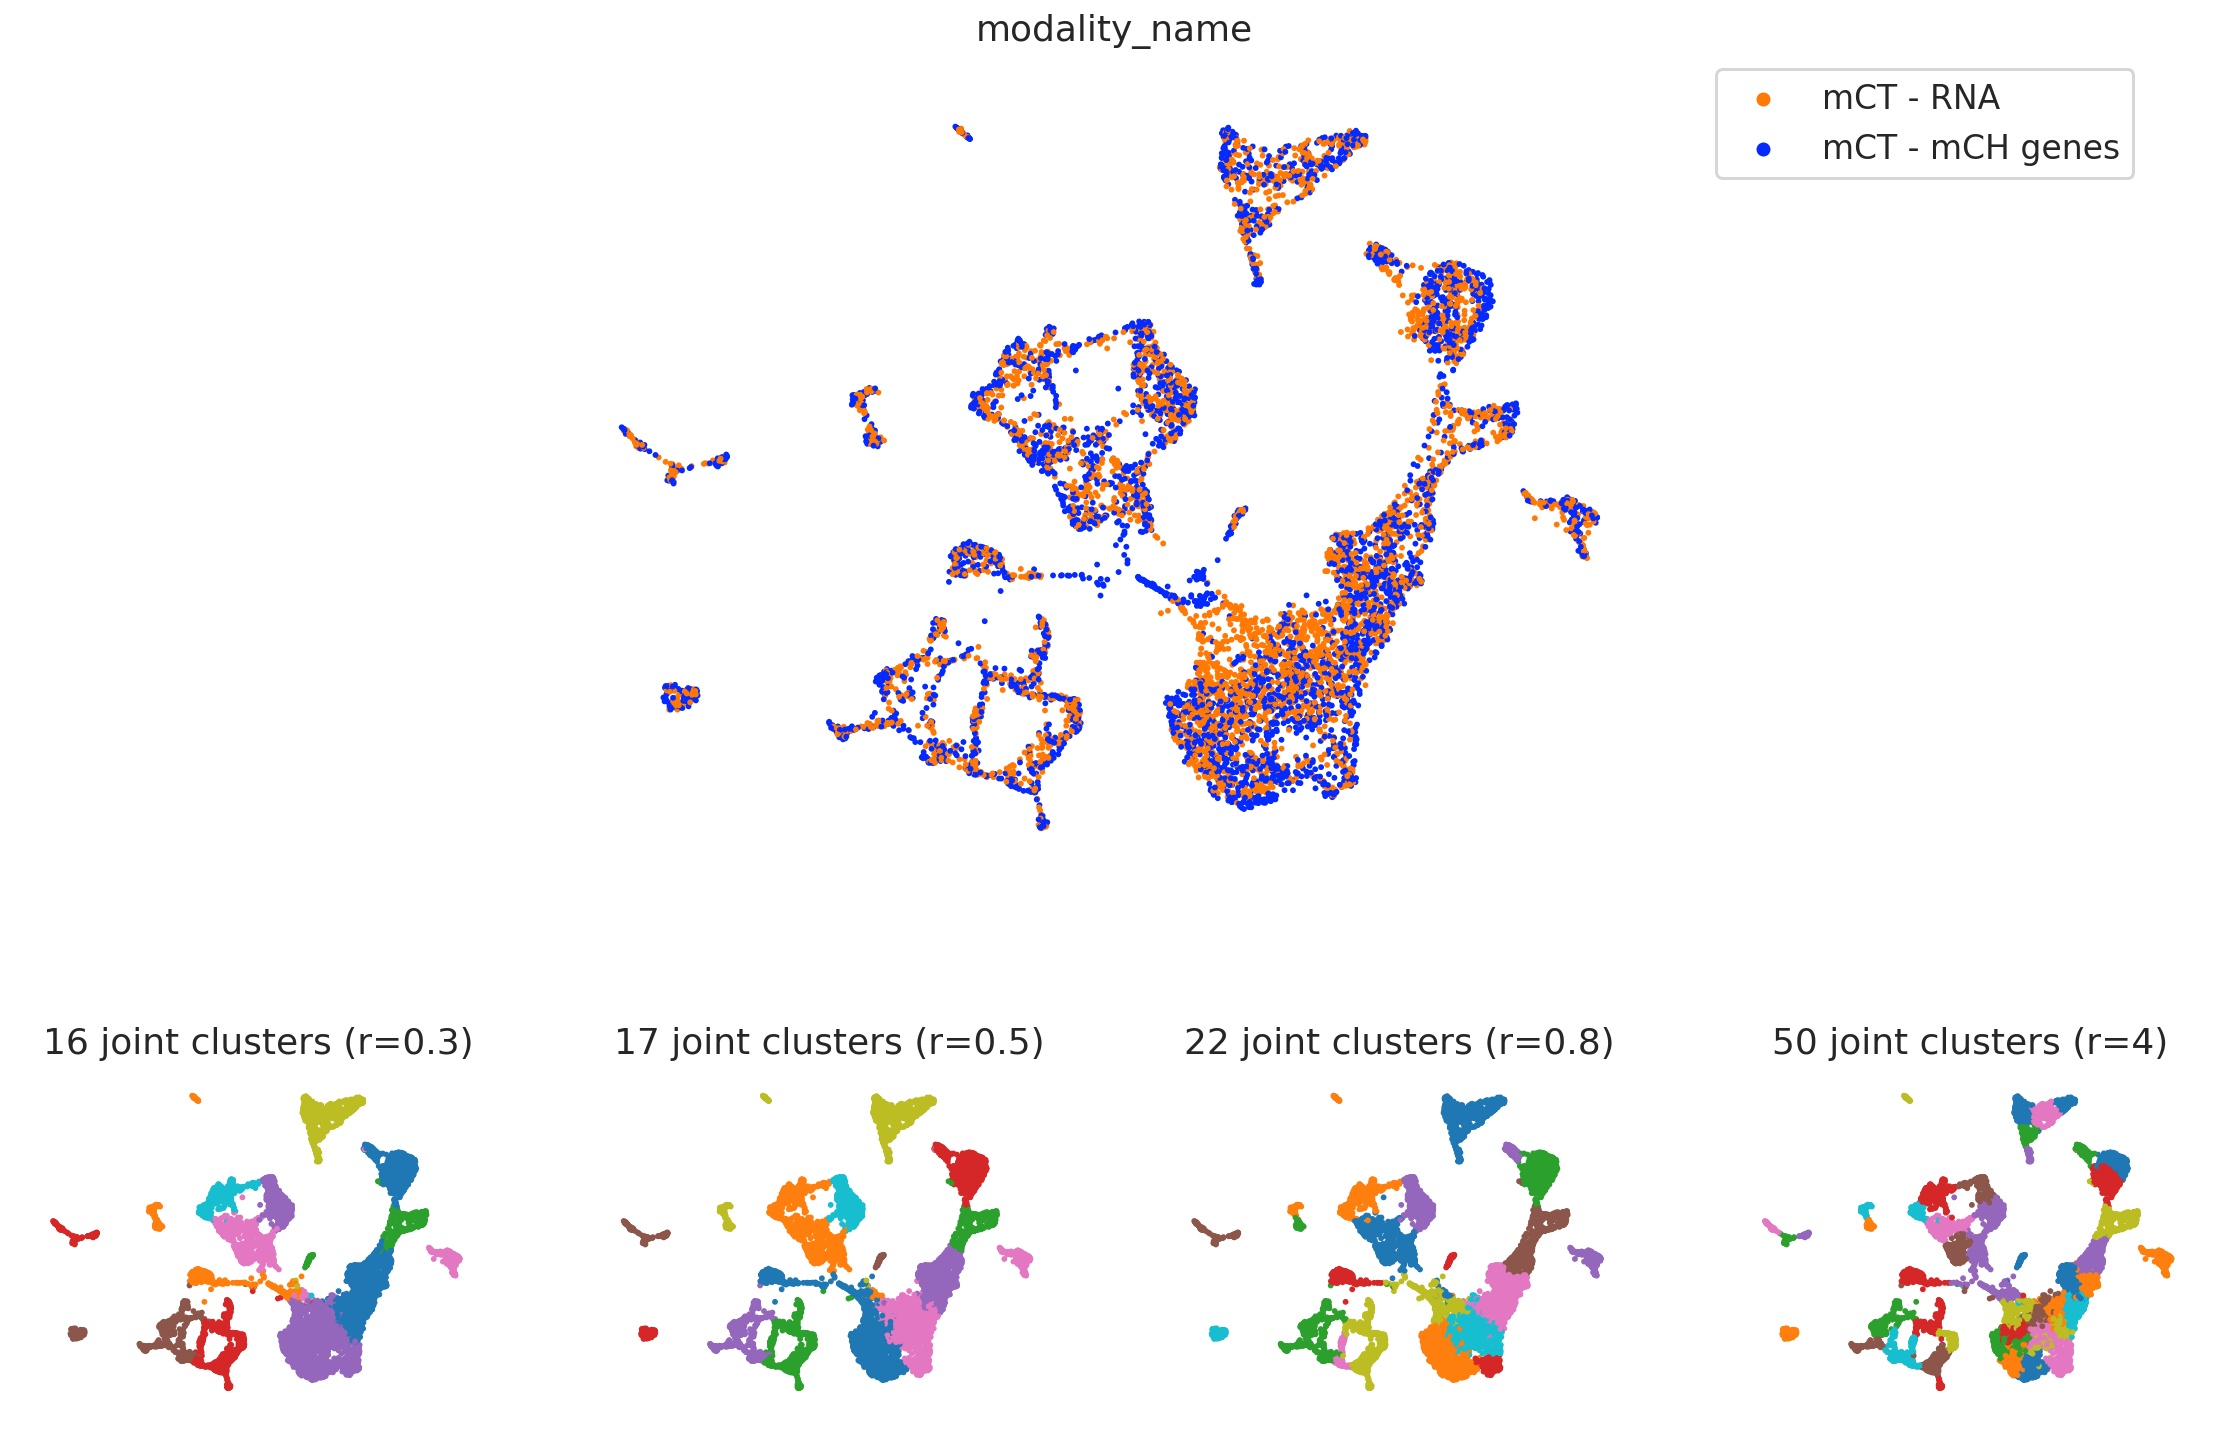

In [23]:
from matplotlib.gridspec import GridSpec

sample_n = min(len(df_info), 50000)
with sns.plotting_context('talk'):
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, 4)
    
    ax = fig.add_subplot(gs[0, :])
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    basic_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=mod_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    
    layouts = [(1, 0), (1, 1), (1, 2), (1, 3)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        basic_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))
    
    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    


In [24]:
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())


for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r0.3']]
             .groupby(['cluster_joint_r0.3']).median())

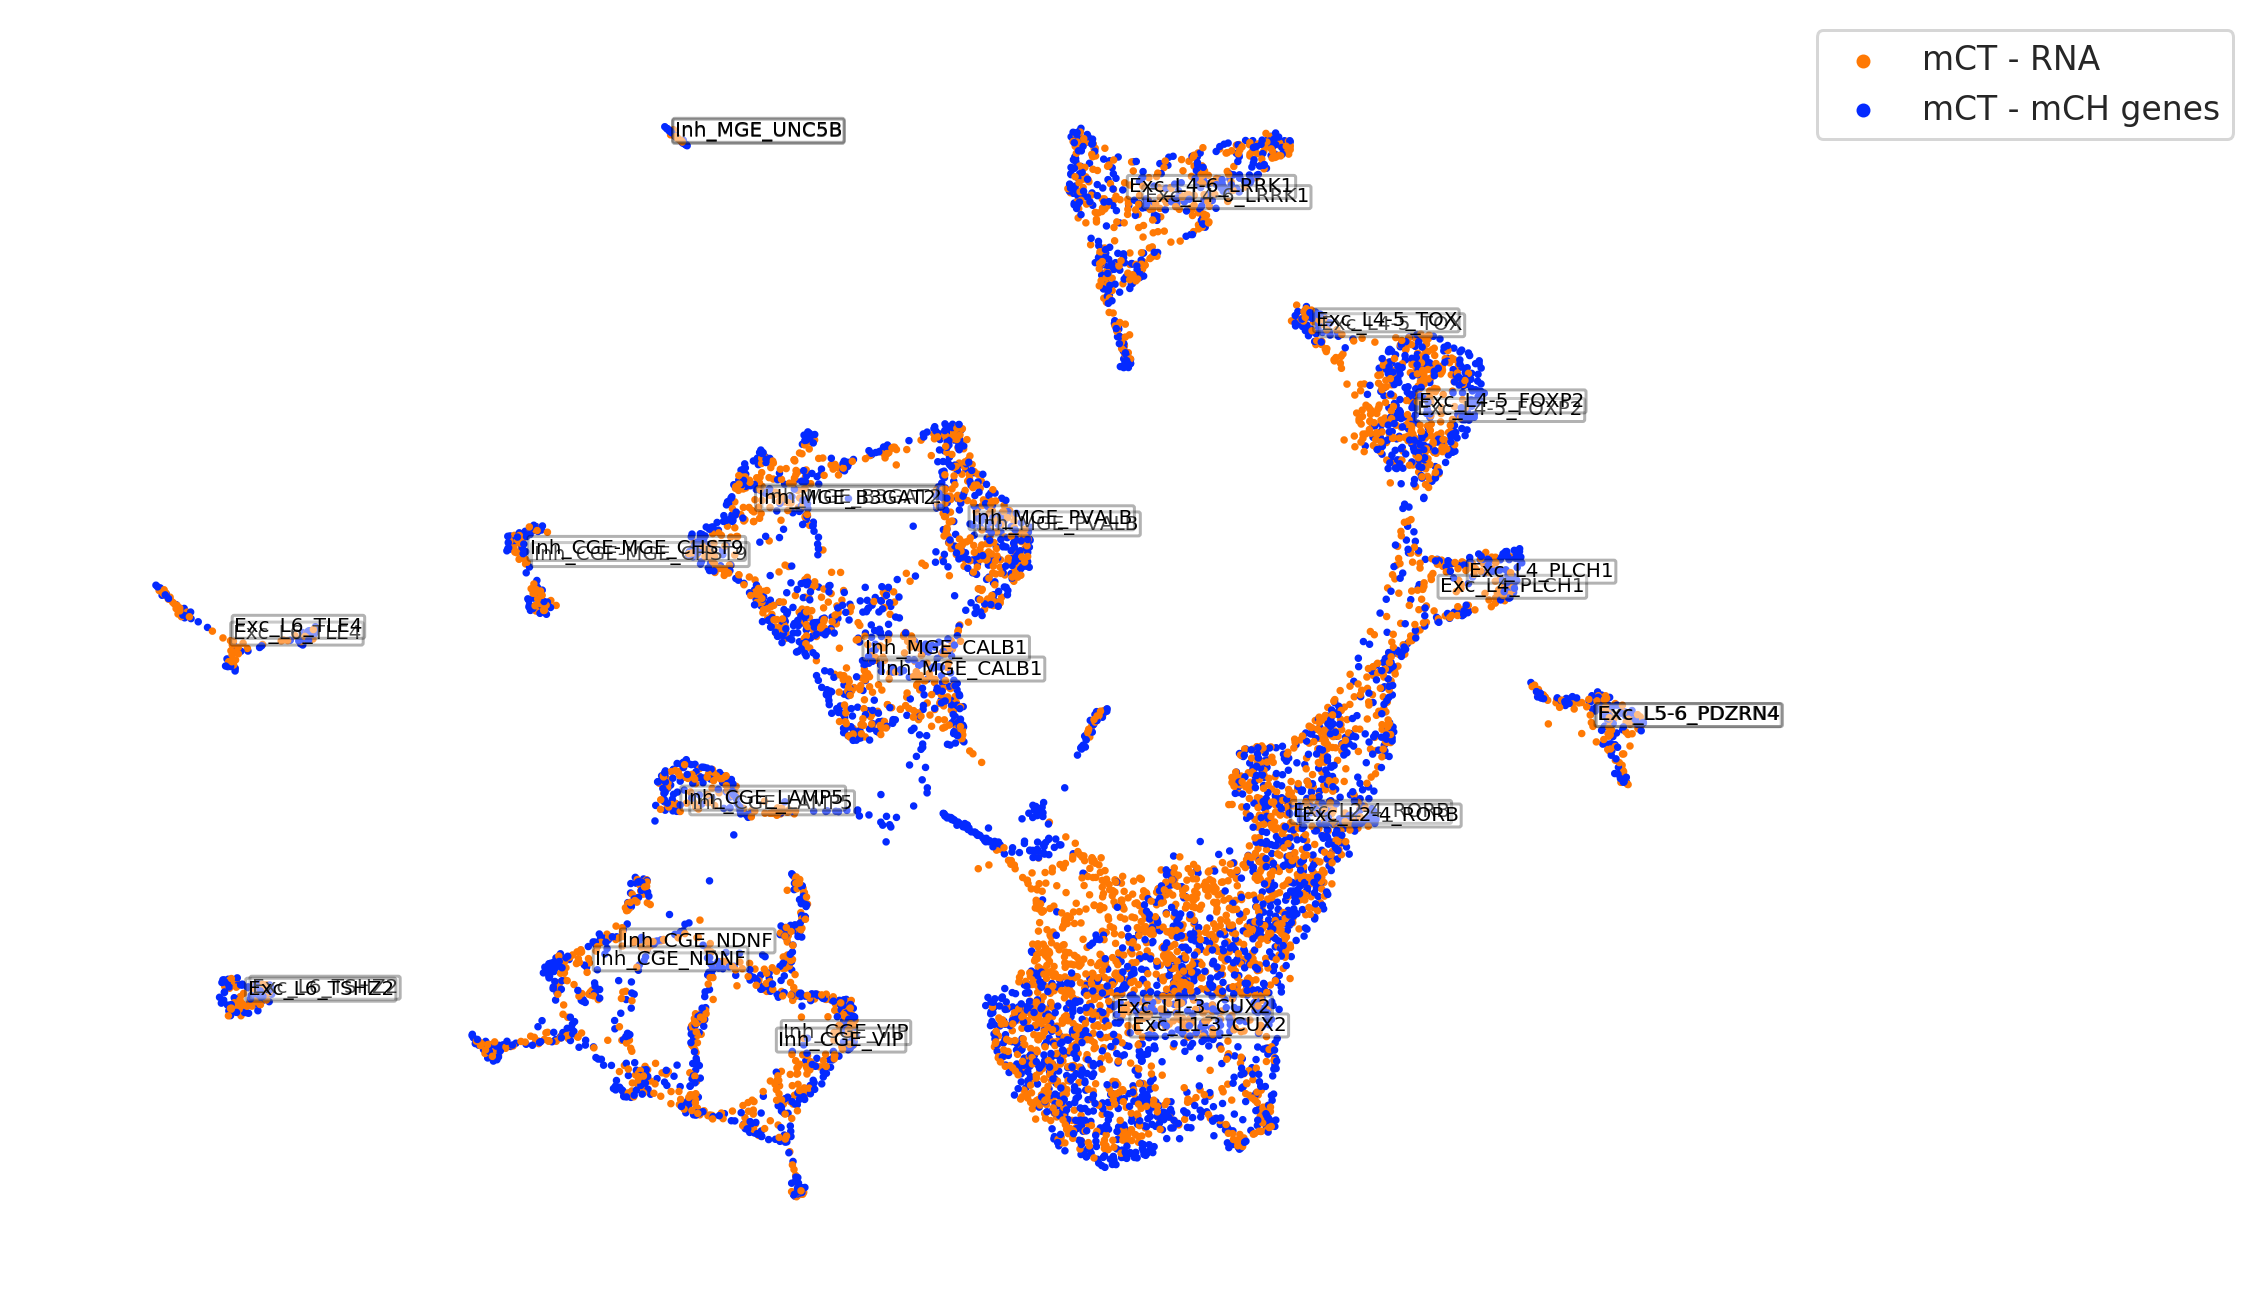

In [25]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(16*1,16*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    basic_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=mod_colors,
                                      s=5,
                                     )
    ax.set_aspect('equal')
    ax.set_title('')
    ax.axis('off')
    
    # add labels
    for mod in mods_selected:
        for clst, centroid in centroids[mod].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    clst,
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )
    
    fig.savefig(output_figures.format(2, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

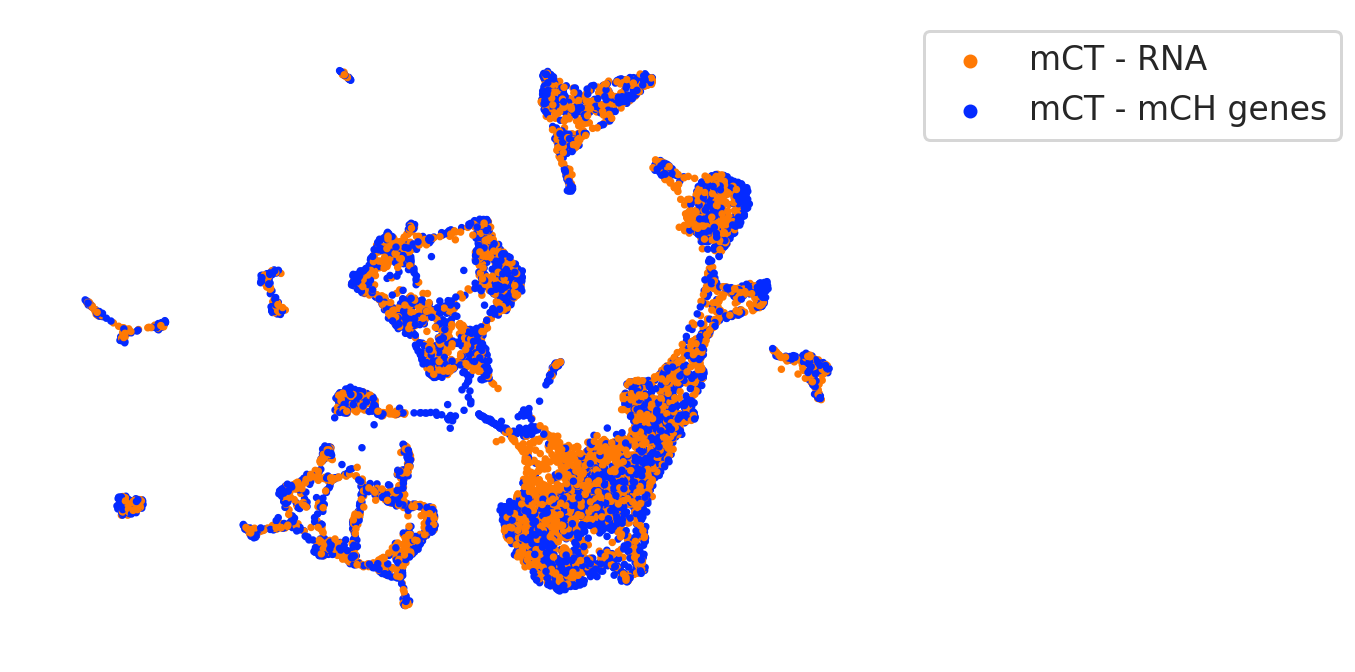

In [26]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    basic_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=mod_colors,
                                      s=5,
                                     )
    ax.set_aspect('equal')
    ax.set_title('')
    ax.axis('off')
    
    fig.savefig(output_figures.format('2-nolabel', 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

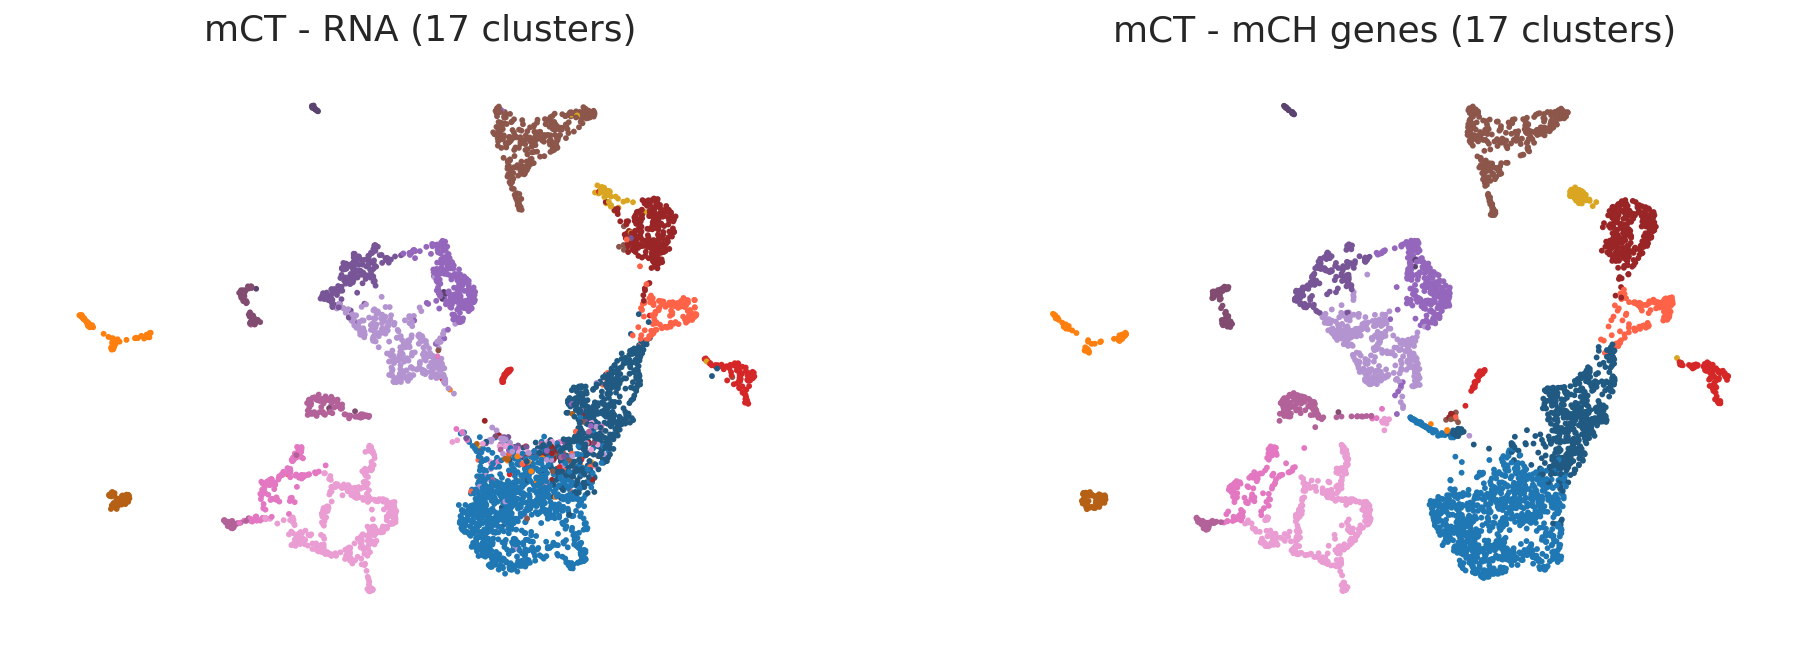

In [27]:
with sns.plotting_context('talk'):
    n = len(mods_selected)
    nx = 2
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(8*nx,8*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'annot'
    
    for ax, mod in zip(axs, mods_selected):
        basic_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          kw_colors=majortype_colors,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')
        
    
    fig.savefig(output_figures.format('3-major', 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

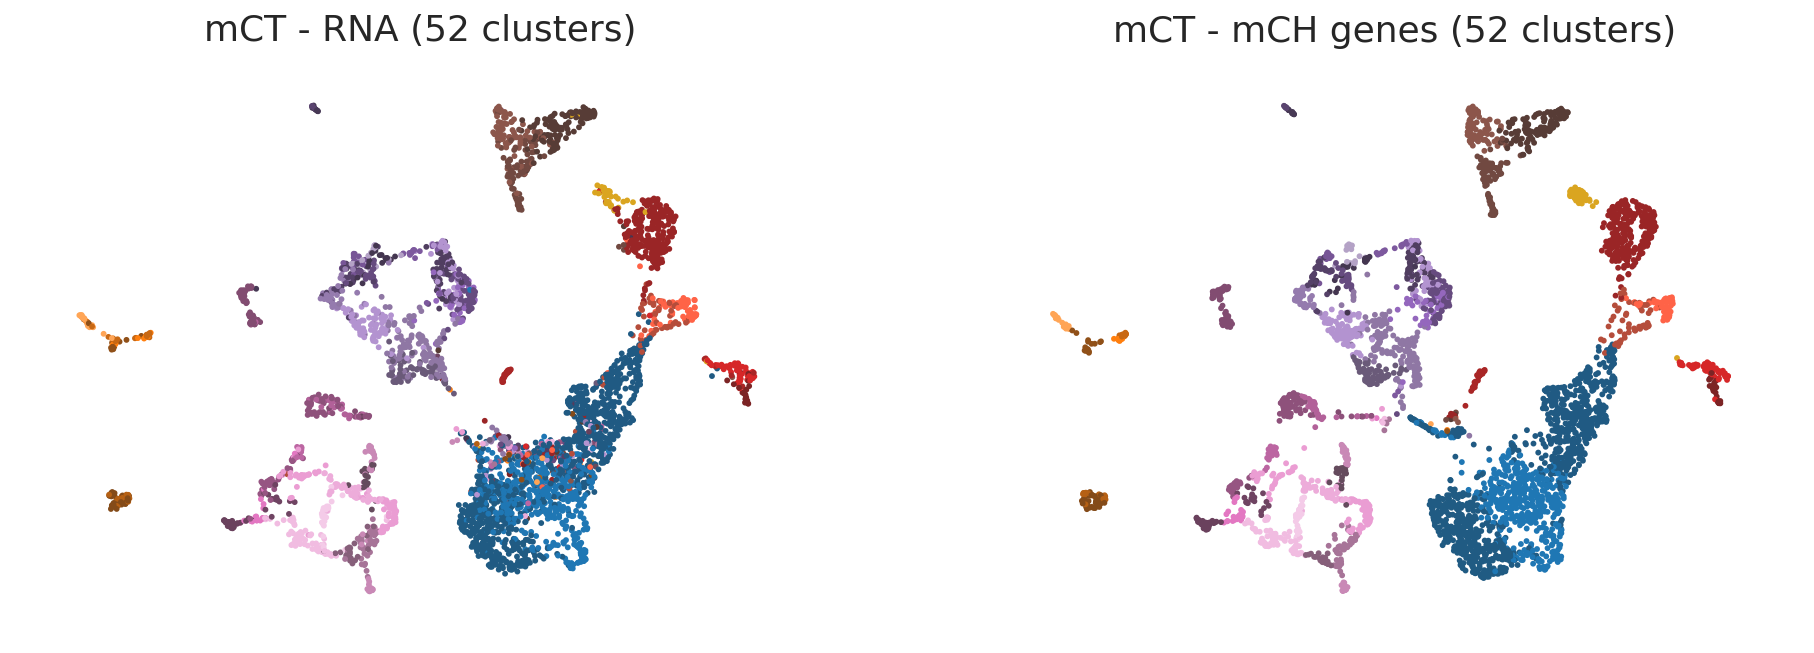

In [28]:
with sns.plotting_context('talk'):
    n = len(mods_selected)
    nx = 2
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(8*nx,8*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'sub_annot'
    
    for ax, mod in zip(axs, mods_selected):
        basic_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          kw_colors=subtype_colors,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')
        
    
    fig.savefig(output_figures.format('3-sub', 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

In [29]:
# histograms
joint_cluster_col = 'cluster_joint_r0.3'
hist = df_info.groupby([joint_cluster_col, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

hist_frac_pairs = pd.DataFrame()
fracs = []
clsts = []
grand_total = 0
grand_pairs = 0
for clst, df_sub in df_info.groupby(joint_cluster_col):
    cells = df_sub.index.values
    cells = [cell[:-4] for cell in cells]
    total = len(cells)
    uniq = len(np.unique(cells))
    frac = 2*(1-uniq/total)
    grand_total += total
    grand_pairs += int(total*frac)
    fracs.append(frac)
    clsts.append(clst)
hist_frac_pairs['clst'] = clsts    
hist_frac_pairs['frac'] = fracs
grand_frac = grand_pairs/grand_total
print(grand_frac)

0.870574653668548


In [30]:
intg_annot = df_info.groupby([joint_cluster_col]).agg(lambda x:x.value_counts().index[0])['annot']

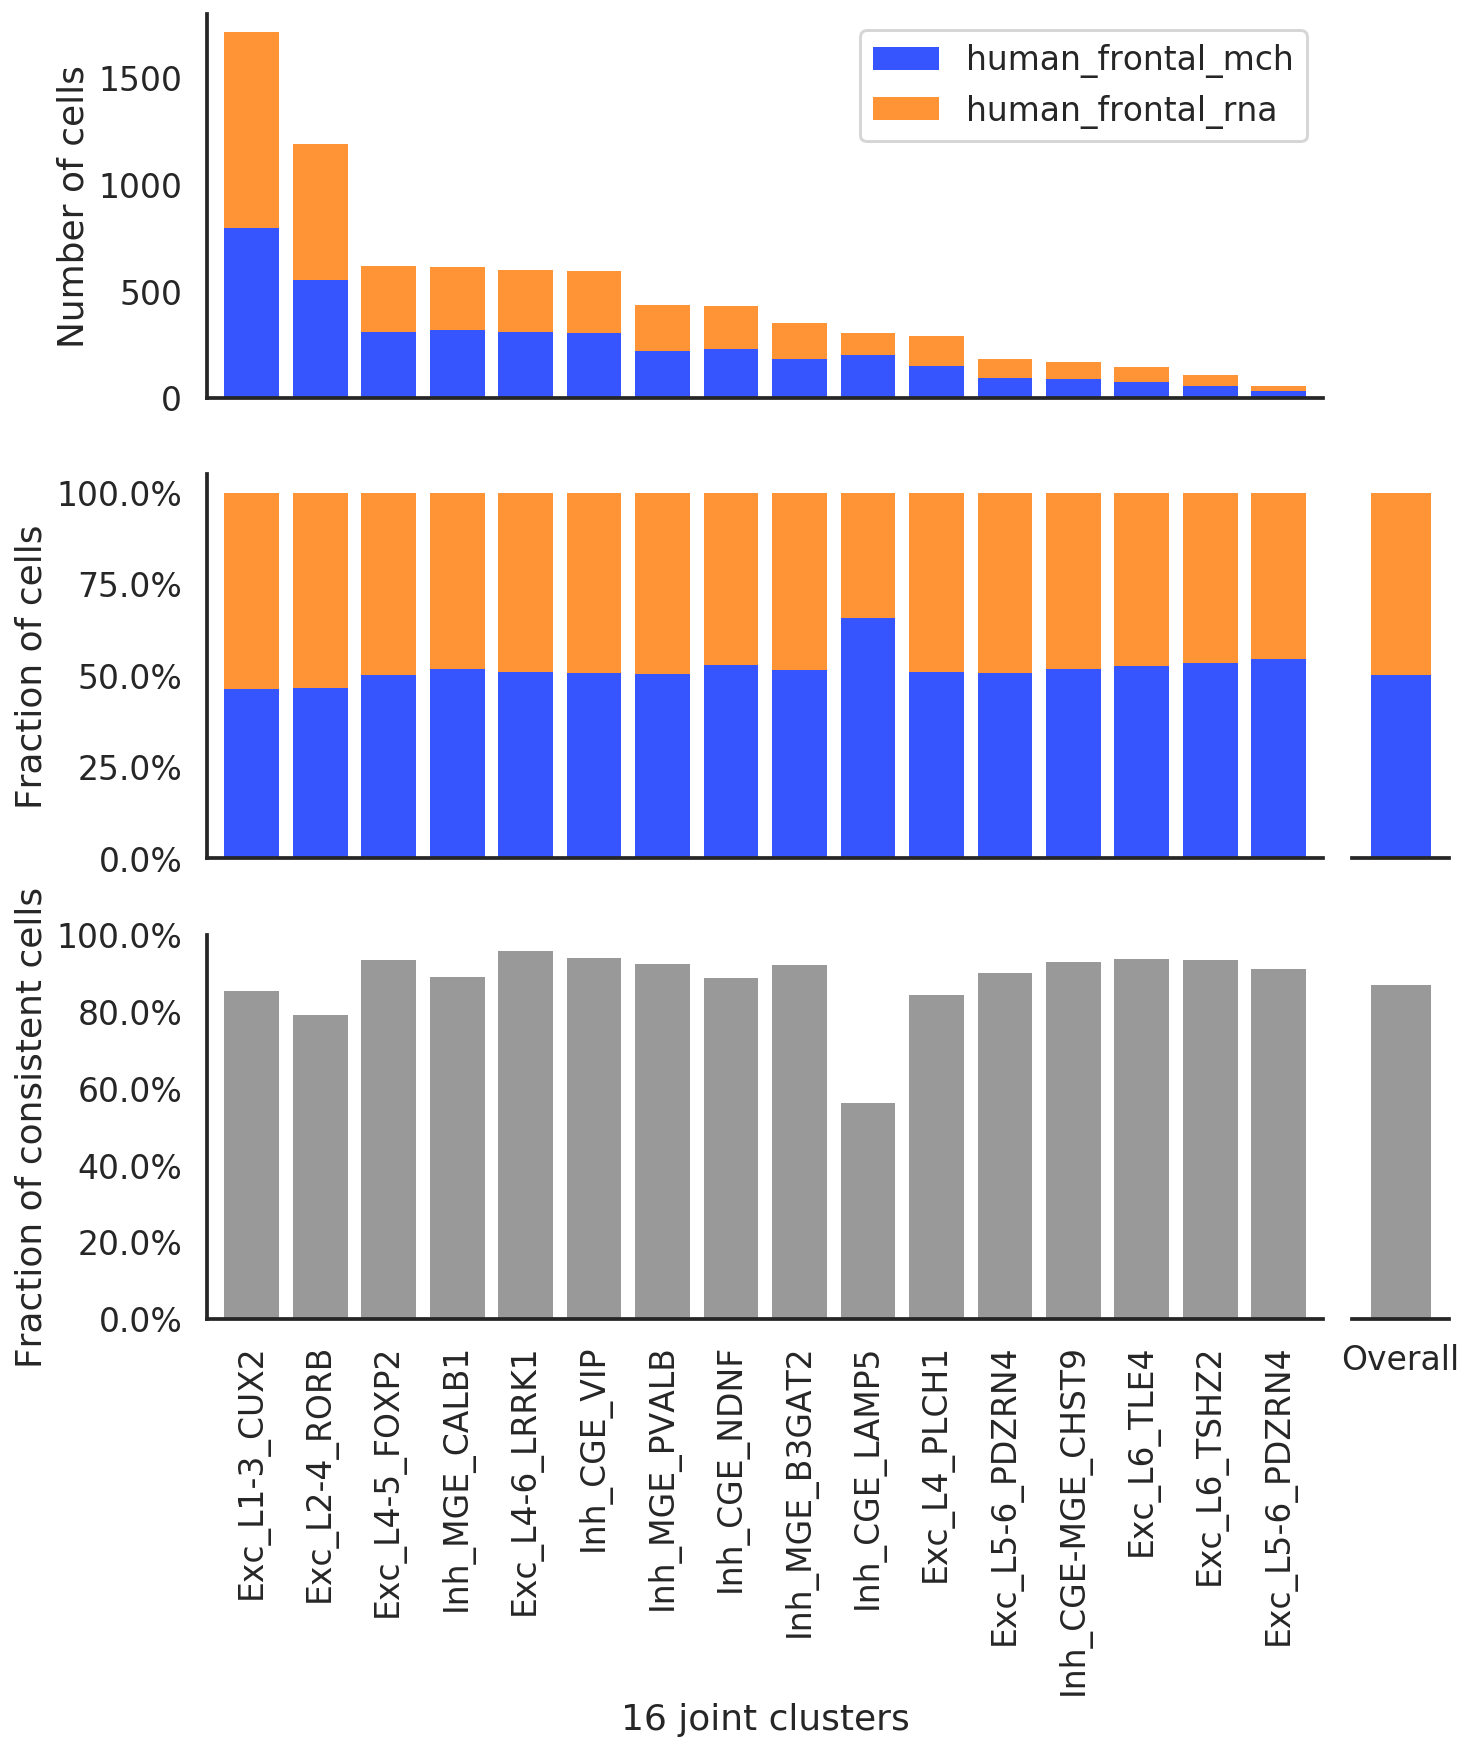

In [31]:
PercentFormat = mtick.FuncFormatter(lambda y, _: '{:.1%}'.format(y))
with sns.plotting_context('talk'), sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    # histograms
    fig, axs = plt.subplots(3, 1, figsize=(10,4*3))
    ax = axs[0]
    hist[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                                       color=[mod_colors[mod] for mod in mods_selected[::-1]],
                                      )
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                       color=[mod_colors[mod] for mod in mods_selected[::-1]],
                 )
    sns.despine(ax=ax)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.yaxis.set_major_formatter(PercentFormat)
    
    # extra
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_selected[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False,
                                color=[mod_colors[mod] for mod in mods_selected[::-1]],
                               )
    )
    sns.despine(ax=ax, left=True)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    ax = axs[2]
    hist_frac_pairs[['frac']].plot.bar(width=0.8, alpha=0.8, legend=False, ax=ax, color='gray')
    sns.despine(ax=ax)
    ax.set_xticklabels(intg_annot.values)
    ax.set_ylabel('Fraction of consistent cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_formatter(PercentFormat)
    
    # extra
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    
    pd.DataFrame([{'Overall': grand_frac}]).T.plot.bar(width=0.8, alpha=0.8, legend=False, ax=ax, color='gray')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    sns.despine(ax=ax, left=True)
    ax.set_ylim([0, 1])
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    fig.savefig(output_figures.format(4, 'pdf'), bbox_inches='tight')
    plt.show()

In [32]:
# histograms
joint_cluster_col = 'cluster_joint_r4'
hist = df_info.groupby([joint_cluster_col, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

hist_frac_pairs = pd.DataFrame()
fracs = []
clsts = []
grand_total = 0
grand_pairs = 0
for clst, df_sub in df_info.groupby(joint_cluster_col):
    cells = df_sub.index.values
    cells = [cell[:-4] for cell in cells]
    total = len(cells)
    uniq = len(np.unique(cells))
    frac = 2*(1-uniq/total)
    grand_total += total
    grand_pairs += int(total*frac)
    fracs.append(frac)
    clsts.append(clst)
hist_frac_pairs['clst'] = clsts    
hist_frac_pairs['frac'] = fracs
grand_frac = grand_pairs/grand_total
print(grand_frac)

intg_annot = df_info.groupby([joint_cluster_col]).agg(lambda x:x.value_counts().index[0])['annot']

0.620831195484864


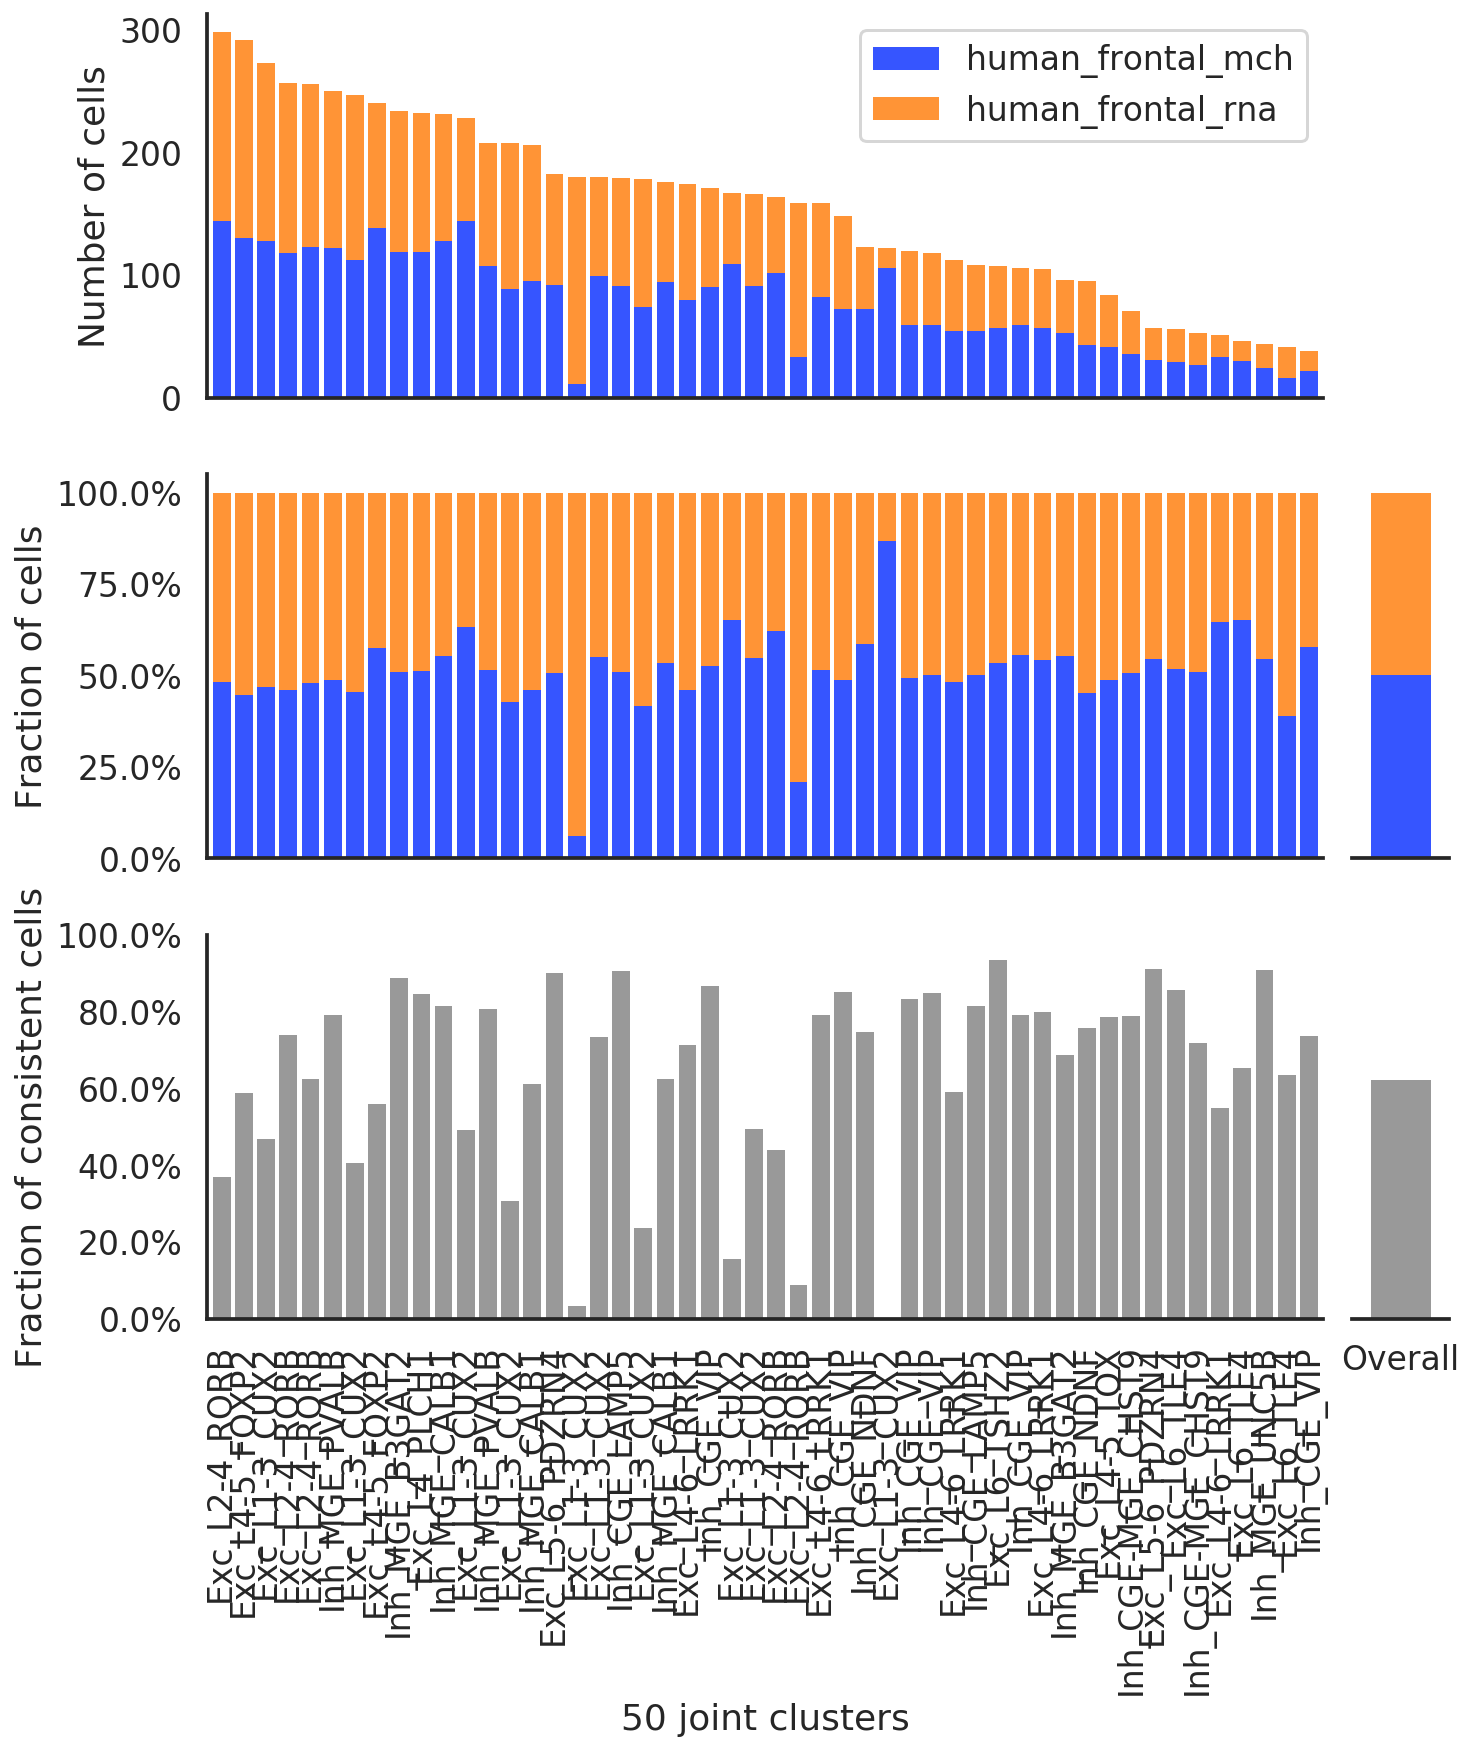

In [33]:
with sns.plotting_context('talk'), sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    # histograms
    fig, axs = plt.subplots(3, 1, figsize=(10,4*3))
    ax = axs[0]
    hist[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                                       color=[mod_colors[mod] for mod in mods_selected[::-1]],
                                      )
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                       color=[mod_colors[mod] for mod in mods_selected[::-1]],
                 )
    sns.despine(ax=ax)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.yaxis.set_major_formatter(PercentFormat)
    
    # extra
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_selected[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False,
                                color=[mod_colors[mod] for mod in mods_selected[::-1]],
                               )
    )
    sns.despine(ax=ax, left=True)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    ax = axs[2]
    hist_frac_pairs[['frac']].plot.bar(width=0.8, alpha=0.8, legend=False, ax=ax, color='gray')
    sns.despine(ax=ax)
    ax.set_xticklabels(intg_annot.values)
    ax.set_ylabel('Fraction of consistent cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_formatter(PercentFormat)
    
    # extra
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    
    pd.DataFrame([{'Overall': grand_frac}]).T.plot.bar(width=0.8, alpha=0.8, legend=False, ax=ax, color='gray')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    sns.despine(ax=ax, left=True)
    ax.set_ylim([0, 1])
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    fig.savefig(output_figures.format('4_sub', 'pdf'), bbox_inches='tight')
    plt.show()

